In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Activation, BatchNormalization, Conv2D, Dense,  GlobalAveragePooling2D,DepthwiseConv2D
from keras.models import Sequential, load_model
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
import os

from tensorflow.keras.models import load_model, save_model

In [2]:

# Define the paths to your dataset
train_data_dir = '/content/FER/TRAIN'
Tune_dir = '/content/FER/TUNE'

# Define the ImageDataGenerator for training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Define the ImageDataGenerator for validation set (no augmentation)

# Define batch size and image size
batch_size = 400
image_size = (128, 128)  # Adjust this based on your image dimensions

# Generate the training set
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training' # Adjust if using different classification settings
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'# Adjust if using different classification settings
)

Tune_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Generate the validation set
Tune_generator = Tune_datagen.flow_from_directory(
    Tune_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  # Adjust if using different classification settings
)


Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


In [38]:
import os
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255  # Normalize pixel values
)

# Flow from directory and save augmented images to a folder
batch_size = 32
save_dir = '/augmented'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

train_data_dir = '/content/FER/TRAIN'
data_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),  # Adjust target size as needed
    batch_size=batch_size,
    class_mode='categorical',  # Change this according to your problem (binary or categorical)
    save_to_dir=save_dir,
    save_prefix='aug',  # Prefix for saved images
    save_format='png'  # Image format for saved images
)

# Generate augmented images and save them to the specified directory
num_images = 100  # Number of augmented images to generate
for i in range(num_images // batch_size):
    batch = data_generator.next()

Found 8000 images belonging to 8 classes.


In [4]:
import tensorflow as tf
import keras
train_data_dir = '/content/FER/TRAIN'
Tune_dir = '/content/FER/TUNE'
train_ds = tf.keras.utils.image_dataset_from_directory(
directory =train_data_dir,
image_size = (128, 128),
validation_split = 0.15,
subset = "training",
seed = 42,
shuffle = True)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_data_dir,
    image_size=(128, 128),
    validation_split=0.15,
    subset="validation",
    seed=42,
    shuffle=True
)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

Found 8000 files belonging to 8 classes.
Using 6800 files for training.
Found 8000 files belonging to 8 classes.
Using 1200 files for validation.


In [28]:
tune_ds = tf.keras.utils.image_dataset_from_directory(
    directory=Tune_dir,
    image_size=(128, 128),
    seed=42,
    shuffle=True
)
tune_ds = tune_ds.map(lambda x, y: (x / 255.0, y))

Found 1600 files belonging to 8 classes.


In [5]:
def depth_conv_block(model, d, k, s):
  model.add(DepthwiseConv2D((k, k), strides=(s, s), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(d, (1, 1), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  return model

model = Sequential()
alpha = 1
dropout=0.3
# CONV
model.add(Conv2D(int(32 * alpha), (3, 3), padding='same', use_bias=False, strides=(2, 2), input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# DEPTHWISE CONVS
model = depth_conv_block(model, int(64 * alpha), 3, 1)

model = depth_conv_block(model, int(128 * alpha), 3, 2)
model = depth_conv_block(model, int(128 * alpha), 3, 1)

model = depth_conv_block(model, int(256 * alpha), 3, 2)
model = depth_conv_block(model, int(256 * alpha), 3, 1)

model = depth_conv_block(model, int(512 * alpha), 3, 2)
model = depth_conv_block(model, int(512 * alpha), 3, 1)
model = depth_conv_block(model, int(512 * alpha), 3, 1)
model = depth_conv_block(model, int(512 * alpha), 3, 1)
model = depth_conv_block(model, int(512 * alpha), 3, 1)
model = depth_conv_block(model, int(512 * alpha), 3, 1)

model = depth_conv_block(model, int(1024 * alpha), 3, 2)
model = depth_conv_block(model, int(1024 * alpha), 3, 1)
# FLATTEN
model.add(GlobalAveragePooling2D())
#model.add(Dropout(dropout))
model.add(Dense(8, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        864       
                                                                 
 batch_normalization_54 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_54 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 depthwise_conv2d_26 (Depth  (None, 64, 64, 32)        288       
 wiseConv2D)                                                     
                                                                 
 batch_normalization_55 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                      

In [6]:
# Compile the model

batch_size=32
epochs=25
from keras.optimizers import Adam
# from tensorflow.python.keras.optimizer_v2 import adam as adam_v2
batch_size=32
epoch=50

optimizer = keras.optimizers.Adam(learning_rate=0.006)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Train the model
train_history = model.fit(
    train_ds,
    batch_size=32,
    epochs=epochs,validation_data=validation_ds
)

Epoch 1/25
213/213 [==============================] - 35s 49ms/step - loss: 2.0052 - accuracy: 0.1974 - val_loss: 2.2207 - val_accuracy: 0.1383
Epoch 2/25
213/213 [==============================] - 11s 53ms/step - loss: 1.6699 - accuracy: 0.2853 - val_loss: 2.6563 - val_accuracy: 0.1383
Epoch 3/25
213/213 [==============================] - 10s 45ms/step - loss: 1.5835 - accuracy: 0.3382 - val_loss: 1.8639 - val_accuracy: 0.2158
Epoch 4/25
213/213 [==============================] - 11s 50ms/step - loss: 1.4684 - accuracy: 0.3956 - val_loss: 1.5247 - val_accuracy: 0.3975
Epoch 5/25
213/213 [==============================] - 11s 49ms/step - loss: 1.3689 - accuracy: 0.4506 - val_loss: 1.5558 - val_accuracy: 0.3858
Epoch 6/25
213/213 [==============================] - 11s 53ms/step - loss: 1.3147 - accuracy: 0.4774 - val_loss: 1.6568 - val_accuracy: 0.4092
Epoch 7/25
213/213 [==============================] - 10s 49ms/step - loss: 1.2294 - accuracy: 0.5143 - val_loss: 1.7887 - val_accuracy:

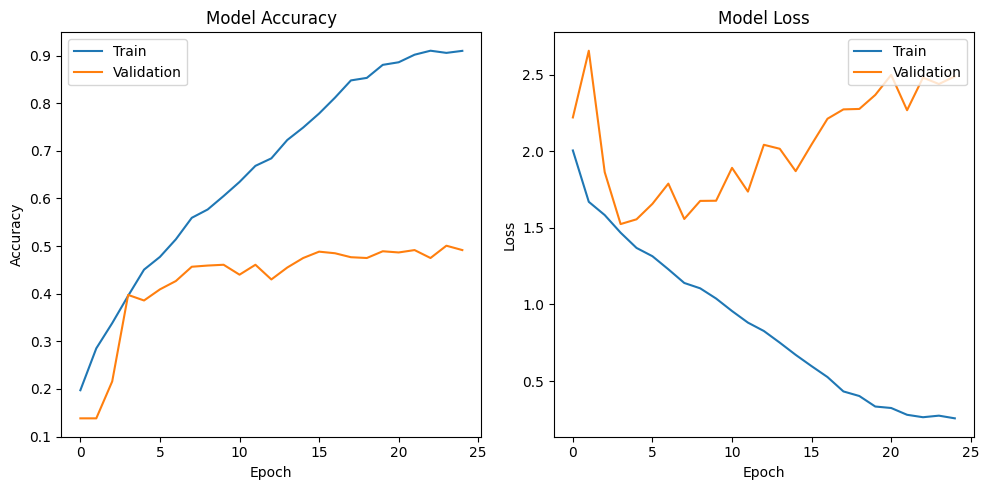

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(train_ds, test_ds, model):
    try:
        # Evaluate the model
        test_loss, test_acc = model.evaluate(test_ds)
        train_loss, train_acc = model.evaluate(train_ds)

        # Get predictions
        train_predictions = np.argmax(model.predict(train_ds), axis=-1)
        test_predictions = np.argmax(model.predict(test_ds), axis=-1)

        # Get true labels
        train_true_labels = np.concatenate([labels.numpy() for _, labels in train_ds])
        test_true_labels = np.concatenate([labels.numpy() for _, labels in test_ds])

        # Calculate confusion matrices
        train_cm = confusion_matrix(train_true_labels, train_predictions)
        test_cm = confusion_matrix(test_true_labels, test_predictions)

        # Print classification reports
        print("\nClassification Report for train:")
        print(classification_report(train_true_labels, train_predictions))

        # For each class, calculate specificity
        train_specificity = [train_cm[i, i] / sum(train_cm[i, :]) for i in range(train_cm.shape[0])]
        print("Train's Specificity:", train_specificity)

        print("\nClassification Report for test:")
        print(classification_report(test_true_labels, test_predictions))

        # For each class, calculate specificity
        test_specificity = [test_cm[i, i] / sum(test_cm[i, :]) for i in range(test_cm.shape[0])]
        print("Test's Specificity:", test_specificity)

        # Plot confusion matrices
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g',
                    xticklabels=list(range(8)),
                    yticklabels=list(range(8)), ax=axes[0])
        axes[0].set_title('Train Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')

        sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g',
                    xticklabels=list(range(8)),
                    yticklabels=list(range(8)), ax=axes[1])
        axes[1].set_title('Test Confusion Matrix')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

        return test_acc, test_loss, train_acc, train_loss

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None, None
